In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import sklearn
from sklearn.mixture import GaussianMixture
import scipy as sp
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.gmm.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *

In [2]:
def convert_grammar_to_gmm(grammar):
    weights = grammar.params_by_node_type[Root.__name__]().detach().numpy()
    means_init = []
    vars_init = []
    for rule_params in grammar.rule_params_by_node_type["Root"]:
        mean = rule_params[0]["mean"]().detach().numpy()
        var = rule_params[0]["variance"]().detach().numpy()
        means_init.append(mean)
        vars_init.append(var)
    means_init = np.stack(means_init)
    vars_init = np.stack(vars_init)
    return make_gmm_without_fitting(weights, means_init, vars_init)

def make_gmm_without_fitting(weights_init, means_init, vars_init):
    gmm = GaussianMixture(
        n_components=3,
        covariance_type="diag"
    )
    gmm.weights_ = deepcopy(weights_init)
    gmm.means_ = deepcopy(means_init)
    gmm.covariances_ = deepcopy(vars_init)
    gmm.precisions_ = 1./deepcopy(vars_init)
    gmm.precisions_cholesky_ = 1.0 / np.sqrt(vars_init)
    gmm.converged_ = True
    return gmm

def convert_gmm_to_grammar(gmm):
    grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4),
        sample_params_from_prior=True
    )
    rule_probs_param = grammar.params_by_node_type[Root.__name__]
    rule_probs_param.set(torch.tensor(deepcopy(gmm.weights_)))

    for k, rule_params in enumerate(grammar.rule_params_by_node_type["Root"]):
        mean_param = rule_params[0]["mean"]
        var_param = rule_params[0]["variance"]
        mean_param.set(torch.tensor(deepcopy(gmm.means_[k, :])))
        var_param.set(torch.tensor(deepcopy(gmm.covariances_[k, :])))
    return grammar


def make_random_gmm(seed):
    pyro.set_rng_seed(seed)
    # Come up with weights / means / variances manually
    weights = dist.Dirichlet(torch.ones(3)).sample().detach().numpy()
    means = dist.Uniform(torch.ones(3, 3)*-10., torch.ones(3, 3)*10.).sample().detach().numpy()
    vars = dist.Uniform(torch.ones(3, 3)*0.5, torch.ones(3, 3)*1.0).sample().detach().square().numpy()
    return make_gmm_without_fitting(weights, means, vars)
    
def make_target_grammar_and_data(seed, N):
    gmm = make_random_gmm(seed)
    X = gmm.sample(N)[0]
    return convert_gmm_to_grammar(gmm), X    
    
N_EM_ITERS_DEFAULT = 5
def do_sklearn_gmm_fit(X, weights_init, means_init, vars_init, n_em_iters=N_EM_ITERS_DEFAULT):
    gmm = make_gmm_without_fitting(weights_init, means_init, vars_init)
    # Run EM updates myself, copying internal code. I'm having trouble
    # forcing it to accept my initialization; I think this line
    # https://github.com/scikit-learn/scikit-learn/blob/0d378913be6d7e485b792ea36e9268be31ed52d0/sklearn/mixture/_gaussian_mixture.py#L730
    # should initialize to the sqrt instead of the covariance...
    for iter_k in range(n_em_iters):
        log_prob_norm, log_resp = gmm._e_step(X)
        gmm._m_step(X, log_resp)
    return convert_gmm_to_grammar(gmm)


def do_grammar_gmm_fit(X, weights_init, means_init, vars_init, n_em_iters=N_EM_ITERS_DEFAULT):
    # Make fitting grammar
    fit_grammar = SpatialSceneGrammar(
        root_node_type = Root,
        root_node_tf = torch.eye(4),
        sample_params_from_prior=True
    )
    rule_probs_param = fit_grammar.params_by_node_type[Root.__name__]
    rule_probs_param.set(torch.tensor(deepcopy(weights_init)))
    for k, rule_params in enumerate(fit_grammar.rule_params_by_node_type["Root"]):
        mean_param = rule_params[0]["mean"]
        var_param = rule_params[0]["variance"]
        mean_param.set(torch.tensor(deepcopy(means_init[k, :])))
        var_param.set(torch.tensor(deepcopy(vars_init[k, :])))
    
    observed_nodes = []
    for x in X:
        observed_nodes.append([Point(tf=drake_tf_to_torch_tf(RigidTransform(p=x)))])
    # Don't clip weights to keep them finite; in this case we won't be infeasible
    # if we do set some weights to zero, and it's a thing that the baseline EM approach
    # doesn't do.
    em = EMWrapper(fit_grammar, observed_nodes, max_scene_extent_in_any_dir=20,
                   parsing_strategy="ip_noproposals", do_nlp_refinement=False)
    em.do_iterated_em_fitting(em_iterations=n_em_iters, tqdm=tqdm, N_solutions=3, num_workers=5,
                   min_weight=10 * np.finfo(weights_init.dtype).eps, weight_by_sample_prob=True)
    return fit_grammar, em

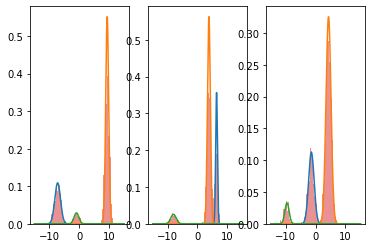

In [3]:
target_grammar, X = make_target_grammar_and_data(11, 1000)


def plot_grammar_modes(grammar, axs):
    xs = np.linspace(-15, 15, 1000)
    for k, label in enumerate("xyz"):
        rule_probs_param = grammar.params_by_node_type[Root.__name__]
        modes = []

        for rule_params in grammar.rule_params_by_node_type["Root"]:
            mean_param = rule_params[0]["mean"]
            var_param = rule_params[0]["variance"]
            modes.append((mean_param(), var_param()))

        for mode_k, (prob, mode) in enumerate(zip(rule_probs_param().detach().numpy(), modes)):
            mode = torch.exp(dist.Normal(mode[0][k], mode[1][k]).log_prob(torch.tensor(xs))).detach().numpy() * prob
            axs[k].plot(xs, mode, label="Mode %d" % mode_k)

def plot_grammar_samples(grammar, axs, X):
    for k, label in enumerate("xyz"):
        axs[k].hist(X[:, k], bins=50, alpha=0.5, density=True)
        
def make_figure_for_grammar(grammar, X, axs):
    plot_grammar_modes(grammar, axs)
    plot_grammar_samples(grammar, axs, X)

fig, axs = plt.subplots(1, 3)
make_figure_for_grammar(target_grammar, X, axs)

In [4]:
def do_comparison_run(seed, N_samples=100, N_restarts=1):
    assert seed >= 0
    target_grammar, X = make_target_grammar_and_data(seed, N_samples)
    gmm_fit_grammars = []
    grammar_fit_grammars = []
    em_histories = []
    init_gmms = []
    for k in range(N_restarts):
        init_gmm = make_random_gmm(seed + k + 1)
        gmm_fit_grammars.append(do_sklearn_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_))
        grammar_fit_grammar, em_history = do_grammar_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_)
        grammar_fit_grammars.append(grammar_fit_grammar)
        em_histories.append(em_history)
        init_gmms.append(init_gmm)
    return {
        "target_grammar": target_grammar,
        "X": X,
        "init_gmms": init_gmms,
        "gmm_fit_grammars": gmm_fit_grammars,
        "grammar_fit_grammars": grammar_fit_grammars,
        "grammar_fit_em_histories": em_histories
    }

def do_comparison_runs(N_runs, save_file):
    if os.path.exists(save_file):
        os.remove(save_file)
    for k in tqdm(range(N_runs)):
        res_dict = do_comparison_run(k)
        with open(save_file, 'ab') as fp:
            pickle.dump(res_dict,fp)

FILENAME = "test_runs_with_restarts.pickle"
RERUN = False
if RERUN or not os.path.exists(FILENAME):
    print("Rerunning experiment...")
    do_comparison_runs(30, FILENAME)
else:
    print("Experiment not being rerun.")

Rerunning experiment...


  0%|          | 0/30 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

EM Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

# Plot results

In [8]:
all_result_dicts = []
with open(FILENAME, "rb") as fp:
    try:
        while True:
            all_result_dicts.append(pickle.load(fp))
    except EOFError:
        pass
print("Loaded %d experiment runs" % len(all_result_dicts))

Loaded 30 experiment runs


[ 0.02257095  0.04084453 -0.10855975 -0.02753315  0.01824826  0.03599287
  0.03980878 -0.07926832  0.08939516  0.06566084  0.10173654 -0.05458153
 -0.04728182 -0.01377595  0.37818923 -0.03666804 -0.03943802 -0.65071256
  0.07442528  0.02573305 -0.06896356 -0.0411719   0.08756684  0.04997881
 -0.02799691 -0.07959473 -0.01755971  0.06748302  0.02713524  0.10913493] 17


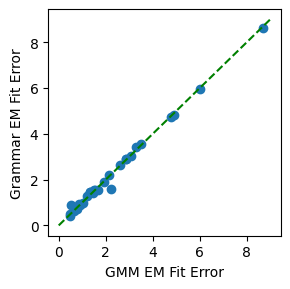

In [9]:
# Histogram of errors
# Extract a large number of samples from the GT and fit models,
# and compare their distance to the GT distribution as a sum of
# the 1D EMD (Wasserstein) distances.
def get_best_model_error(gt_sample, fit_samples):
    return min([
        sum([sp.stats.wasserstein_distance(gt_sample[:, k], fit_sample[:, k]) for k in range(3)])
        for fit_sample in fit_samples
    ])
def make_scatter_of_errors(all_result_dicts, N_samples=10000):
    gmm_errs = []
    grammar_errs = []
    for result_dict in all_result_dicts:
        gt_samples = convert_grammar_to_gmm(result_dict["target_grammar"]).sample(N_samples)[0]
        gmm_fit_samples = [
            convert_grammar_to_gmm(gmm_fit_grammar).sample(N_samples)[0]
            for gmm_fit_grammar in result_dict["gmm_fit_grammars"]
        ]
        grammar_fit_samples = [
            convert_grammar_to_gmm(grammar_fit_grammar).sample(N_samples)[0]
            for grammar_fit_grammar in result_dict["grammar_fit_grammars"]
        ]
        gmm_errs.append(get_best_model_error(gt_samples, gmm_fit_samples))
        grammar_errs.append(get_best_model_error(gt_samples, grammar_fit_samples))
    plt.figure(dpi=100).set_size_inches(3, 3)
    plt.scatter(gmm_errs, grammar_errs)
    plt.xlabel("GMM EM Fit Error")
    plt.ylabel("Grammar EM Fit Error")
    disagreement = np.array(grammar_errs) - np.array(gmm_errs)
    print(disagreement, np.argmax(np.abs(disagreement)))
    plt.plot(np.arange(0., 10.), np.arange(0., 10.), linestyle="--", c="green")
make_scatter_of_errors(all_result_dicts)

Final params:  tensor([0.0100, 0.9752, 0.0148])


No handles with labels found to put in legend.


mean tensor([[-7.2591,  6.4005, -1.4333],
        [ 2.7043,  0.8595, -8.2006],
        [ 2.7471,  0.9069, -8.2919],
        [ 2.7481,  0.9080, -8.2940],
        [ 2.7481,  0.9080, -8.2940],
        [ 2.7481,  0.9080, -8.2940]])
0:xyz:mean final: tensor([ 2.7481,  0.9080, -8.2940])
variance tensor([[9.5105e-01, 2.9047e-01, 9.2184e-01],
        [6.8551e-03, 8.4133e-03, 3.1198e-02],
        [2.0195e-04, 2.4785e-04, 9.1906e-04],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06],
        [1.0000e-06, 1.0000e-06, 1.0000e-06]])
0:xyz:variance final: tensor([1.0000e-06, 1.0000e-06, 1.0000e-06])
mean tensor([[ 9.3445,  3.8295,  4.3147],
        [ 8.0702, -4.6532,  0.8716],
        [ 8.0549, -4.7180,  0.7518],
        [ 8.1008, -4.7399,  0.6860],
        [ 8.1256, -4.7482,  0.6535],
        [ 8.1350, -4.7508,  0.6406]])
1:xyz:mean final: tensor([ 8.1350, -4.7508,  0.6406])
variance tensor([[ 0.4931,  0.4832,  0.8353],
        [10.0000,  1.0651, 10.0000],


No handles with labels found to put in legend.
No handles with labels found to put in legend.


mean tensor([[-0.9620, -8.0522, -9.5987],
        [ 7.6459, -4.5190, -3.0131],
        [ 7.6759, -3.6962, -2.9795],
        [ 7.2386, -3.3351, -2.9758],
        [ 6.2244, -2.5863, -3.4703],
        [ 4.3737, -1.0206, -5.2723]])
2:xyz:mean final: tensor([ 4.3737, -1.0206, -5.2723])
variance tensor([[ 0.8019,  0.9024,  0.7074],
        [ 6.4471,  7.1588,  6.5221],
        [ 9.3618,  7.7755,  9.6797],
        [10.0000,  7.9118, 10.0000],
        [10.0000,  8.3942, 10.0000],
        [ 9.7153,  6.7049, 10.0000]])
2:xyz:variance final: tensor([ 9.7153,  6.7049, 10.0000])


NameError: name 'Modes' is not defined

<Figure size 432x288 with 0 Axes>

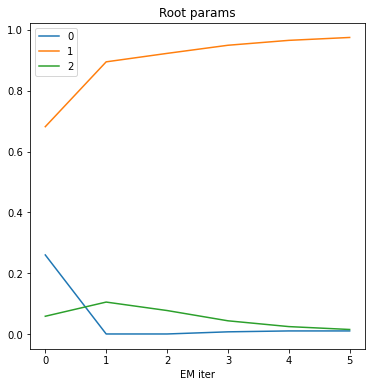

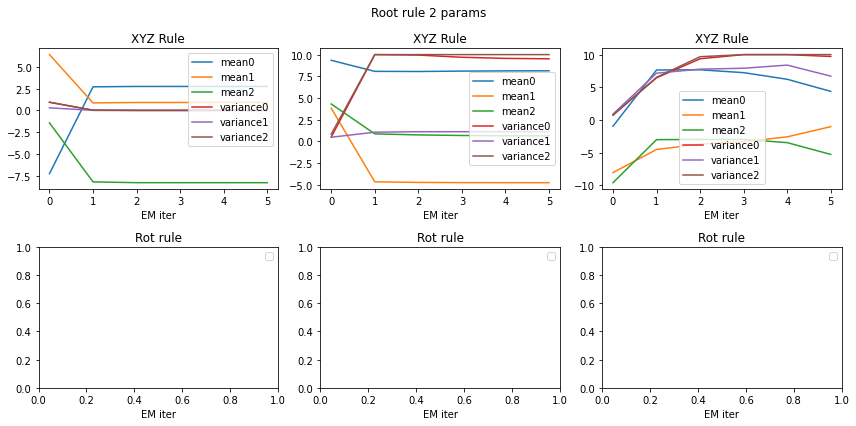

In [7]:
%matplotlib inline
#Make animation of fitting process
from matplotlib.animation import FuncAnimation
from IPython import display

plotting_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)
em = all_result_dicts[10]["grammar_fit_em_histories"][0]
X = all_result_dicts[10]["X"]


plt.figure()
em.plot_grammar_parameter_history(Root)
for mode in Modes:
    print(mode.__name__, ":")
    em.plot_grammar_parameter_history(mode)

    
fig, axs = plt.subplots(1, 3)
#fig.set_dpi(100)

fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")
def update(frame):
    plotting_grammar.load_state_dict(em.grammar_iters[frame])
    for ax in axs:
        ax.cla()
    make_figure_for_grammar(plotting_grammar, X, axs)
    plt.suptitle("MIP-parse + EM fit, iter %02d" % frame)
    for ax in axs:
        ax.set_xlim([-10., 10.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()                   # avoid plotting a spare static plot

# Run GMM EM and Grammar EM in lockstep -- from here on not updated to new formulation, probably.

In [19]:
seed = 10
N_samples = 50
N_steps = 3
target_grammar, X = make_target_grammar_and_data(seed, N_samples)

init_gmm = make_random_gmm(seed + 1)
init_grammar = convert_gmm_to_grammar(init_gmm)

# Get optimal parse for one datapoint
for k in range(X.shape[0]):
    test_observed_points = [Point(tf=drake_tf_to_torch_tf(RigidTransform(p=X[k, :])))]
    inference_results = infer_mle_tree_with_mip(
            init_grammar, test_observed_points, max_scene_extent_in_any_dir=15, N_solutions=3
    )
    mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
    if len(mip_optimized_trees) < 3:
        print("Didn't get enough trees. What gives?")
        print("X: ", X[k, :])
        print("Means: ", init_gmm.means_)
    scores = [mip_optimized_trees[j].score(include_discrete=True).detach().item() for j in range(3)]
    gmm_scores = init_gmm._estimate_weighted_log_prob(X[k:(k+1), :]).flatten()
    for score in scores:
        if np.min(np.abs(gmm_scores - score)) > 1E-2:
            print("Mismatch")
            print(scores, gmm_scores)

In [20]:
log_prob_norm, log_resp = init_gmm._e_step(X)
nk = (np.exp(log_resp).sum(axis=0)) / X.shape[0]
new_weights,  new_means, new_vars = sklearn.mixture._gaussian_mixture._estimate_gaussian_parameters(
            X, np.exp(log_resp), 1E-6, "diag"
)
new_weights /= X.shape[0]
print("gmm update: \n", "weights: ", new_weights, "\nmeans: ",new_means, "\nvars: ", new_vars)

# But doing it with this doesn't get me the same result
new_gmm = convert_grammar_to_gmm(do_sklearn_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_, 1))
print("But using fitting routine: ", "weights: ", new_gmm.weights_)

gmm update: 
 weights:  [4.44089210e-17 9.40787097e-01 5.92129030e-02] 
means:  [[ 8.09478598e-28 -2.39960714e-27  8.89853594e-27]
 [ 8.18682525e+00 -4.63706845e+00  7.77835060e-01]
 [ 8.61520032e+00 -5.72132492e+00 -1.80709235e+00]] 
vars:  [[1.00000000e-06 1.00000000e-06 1.00000000e-06]
 [1.00133260e+01 1.01459009e+00 1.26301432e+01]
 [3.99810459e-01 6.10278131e-01 5.28306647e-01]]
But using fitting routine:  weights:  [4.44089210e-17 9.40787097e-01 5.92129030e-02]


In [21]:
gmm_fit_grammars = [
    do_sklearn_gmm_fit(X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_, k+1)
    for k in range(N_steps)
]
gmm_fit_grammars.insert(0, convert_gmm_to_grammar(init_gmm))
grammar_fit_grammar, em_history = do_grammar_gmm_fit(
    X, init_gmm.weights_, init_gmm.means_, init_gmm.covariances_, N_steps
)

EM Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

ref weights:  [0.25992485 0.68179482 0.05828034]
ref weights:  [4.44089210e-17 9.40787097e-01 5.92129030e-02]
ref weights:  [4.44089210e-17 8.45157578e-01 1.54842422e-01]
[array([[-7.25905584,  6.40045255, -1.43328772],
       [ 9.34452738,  3.82946508,  4.31467805],
       [-0.96201336, -8.0521704 , -9.59873512]]), array([[ 8.09478598e-28, -2.39960714e-27,  8.89853594e-27],
       [ 8.18682525e+00, -4.63706845e+00,  7.77835060e-01],
       [ 8.61520032e+00, -5.72132492e+00, -1.80709235e+00]]), array([[ 0.        ,  0.        ,  0.        ],
       [ 8.05848261, -4.59782157,  0.98707558],
       [ 9.05115609, -5.26591275, -1.35273266]])]
[array([[-7.25905584,  6.40045255, -1.43328772],
       [ 9.34452738,  3.82946508,  4.31467805],
       [-0.96201336, -8.0521704 , -9.59873512]]), array([[ 0.78068084, -2.31423947,  8.58196443],
       [ 8.18682525, -4.63706845,  0.77783506],
       [ 8.61520032, -5.72132492, -1.80709235]]), array([[ 0.78070148, -2.3142085 ,  8.581885  ],
       [ 8.24

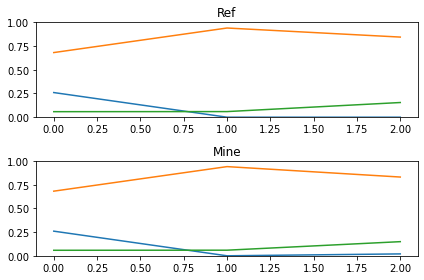

In [22]:
ref_weights_history = []
my_weights_history = []
ref_means_history = []
my_means_history = []
plotting_grammar = SpatialSceneGrammar(
    root_node_type = Root,
    root_node_tf = torch.eye(4)
)
for k in range(N_steps):
    ref_gmm = convert_grammar_to_gmm(gmm_fit_grammars[k])
    ref_weights_history.append(ref_gmm.weights_)
    ref_means_history.append(ref_gmm.means_)
    print("ref weights: ", ref_gmm.weights_)
    plotting_grammar.load_state_dict(em_history.grammar_iters[k])
    my_gmm = convert_grammar_to_gmm(plotting_grammar)
    my_weights_history.append(my_gmm.weights_)
    my_means_history.append(my_gmm.means_)
    
plt.figure()
plt.subplot(2, 1, 1)
plt.title("Ref")
ref_weight_history = np.stack(ref_weights_history)
plt.plot(ref_weight_history, label="Reference")
plt.ylim([0., 1.])
plt.subplot(2, 1, 2)
plt.title("Mine")
my_weight_history = np.stack(my_weights_history)
plt.plot(my_weight_history, label="Mine")
plt.ylim([0., 1.])
plt.tight_layout()

print(ref_means_history)
print(my_means_history)
    
fig, axs = plt.subplots(2, 3)
#fig.set_dpi(100)

fig.set_size_inches(18, 6)
plt.suptitle("MIP-parse + EM fit")
def update(frame):
    plotting_grammar.load_state_dict(em_history.grammar_iters[frame])
    for ax in axs.flatten():
        ax.cla()
    make_figure_for_grammar(plotting_grammar, X, axs[0, :])
    make_figure_for_grammar(gmm_fit_grammars[frame], X, axs[1, :])
    plt.suptitle("Mine (top), baseline (bottom), iter %02d" % frame)
    for ax in axs.flatten():
        ax.set_xlim([-10., 10.])
        ax.set_ylim([0., 0.7])
ani = FuncAnimation(fig, update, frames=range(len(em_history.grammar_iters)), blit=False, interval=500.)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
plt.close()              


In [23]:
inference_results = infer_mle_tree_with_mip(
        grammar_fit_grammar, [Point(tf=drake_tf_to_torch_tf(RigidTransform(p=[9., 3., 5.])))], verbose=True,
        max_scene_extent_in_any_dir=20,
        N_solutions=3
)
mip_optimized_trees = get_optimized_trees_from_mip_results(inference_results)
for k in range(3):
    print(mip_optimized_trees[k].score(), mip_optimized_trees[k].nodes)

Starting setup.
Activation vars allocated.
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  0.016243457794189453
Num vars:  40
Num constraints:  141
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Mon Jan 10 20:59:55 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 126 rows, 40 columns and 395 nonzeros
Model fingerprint: 0xa059bac3
Model has 9 quadratic objective terms
Variable types: 30 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 5e+01]
  Objective range  [5e-01, 2e+01]
  QObjective range [1e-01, 1e+06]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 5e+01]
Presolve removed 53 rows and 19 columns
Presolve time: 0.00s
Presolved: 73 rows, 21 columns, 255 nonzeros
Variable types: 18 continuous, 3 integer (3 binary)

Root relaxation: objective 2.991726e+01, 22 iterations, 0.00 seconds

    Nodes    |    Current Node    |     O